In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(0)

Why we use neural network to approximate the solution?
We know that V is non-negative, convex, even, and V(0) = 0 

In [37]:
def NN_plot(nn):
    nn.compile(loss = 'mse')
    xgrid = np.linspace(-10,10,201)
    y = nn.predict(xgrid)
    plt.plot(xgrid,y)
    plt.grid()
#     plt.show()

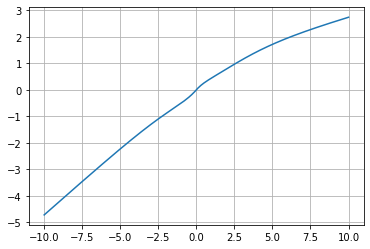

In [40]:
# Independent Control Neural Network: u(x)
inputs = keras.Input(shape=(1))
inputs0 = tf.zeros_like(inputs)

l1 = layers.Dense(8, activation = 'elu')
l2= layers.Dense(8, activation = 'elu')
l3= layers.Dense(1, activation = 'linear')

outputs = l1(inputs)
outputs = l2(outputs)
outputs = l3(outputs)

# outputs0 = l1(inputs0)
# outputs0 = l2(outputs0)
# outputs0 = l3(outputs0)

# outputs = outputs - outputs0

# outputs = -inputs
control_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'control_NN')
# control_NN.summary()
NN_plot(control_NN)

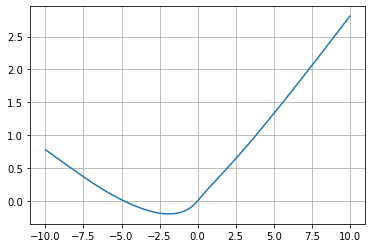

In [43]:
# Value Neural Network: V(x)
inputs = keras.Input(shape=(1))
inputs0 = tf.zeros_like(inputs)

l1 = layers.Dense(8, activation = 'elu')
l2= layers.Dense(8, activation = 'elu')
l3= layers.Dense(1, activation = 'linear')

outputs = l1(inputs)
outputs = l2(outputs)
outputs = l3(outputs)

outputs0 = l1(inputs0)
outputs0 = l2(outputs0)
outputs0 = l3(outputs0)

outputs = outputs - outputs0

# outputs = inputs**2
value_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'value_NN')
# value_NN.summary()
NN_plot(value_NN)

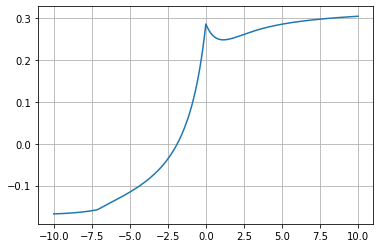

In [44]:
# derivative of Value Neural Network: dV(x)/dx
inputs = keras.Input(shape=(1))
with tf.GradientTape() as t:
    t.watch(inputs)
    outputs0 = value_NN(inputs)
# dy = 2x
outputs = t.gradient(outputs0, inputs)
d_value_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'd_value_NN')
# d_value_NN.summary()
NN_plot(d_value_NN)

In [45]:
# optimal value: rho
inputs = keras.Input(shape=(1))
l= layers.Dense(1, activation = 'linear')
outputs = l(inputs)
rho_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'rho')
# rho_NN.summary()
rho_NN.predict(np.zeros(1))[0,0]

0.0

In [7]:
# Global Parameter
steps = 100
dt = 0.01
sqrtdt = np.sqrt(dt)
T = steps * dt
M = 1000

\begin{equation*}
     \left\{
     \begin{aligned}
          L_{n}(\theta) &= \mathbb{E}\Bigg[\Bigg( V^{\theta}(X_{t_{n+1}}) + \int_{t_{n}}^{t_{n+1}} \Big[c(X_{t},u^{\theta}(X_{t}))-\rho
          ^{\theta}\Big]dt - \int_{t_{n}}^{t_{n+1}}\frac{dV^{\theta}}{dx}(X_{t})\sigma(X_{t})dW_{t} - V^{\theta}(X_{t_{n}}) \Bigg)^2\Bigg] \\
          \theta_{n}^{*} &= \arg\min_{\theta \in \Theta}L_{n}(\theta)
     \end{aligned}
     \right.
\end{equation*}


In [8]:
# under optimal control
input_x = keras.Input(shape=(1))
inputs = [input_x]
X_start = input_x
X_now = X_start
loss = tf.zeros_like(X_now)
bsde = tf.zeros_like(X_now)
loss_output = [loss]
rho = rho_NN(tf.zeros_like(X_now))

for i in range(steps):
    input_dW = keras.Input(shape=(1))
    inputs = inputs + [input_dW]
    u_now = -X_now              # Here we use the optimal control
    X_next  = X_now + input_dW + u_now * dt
    loss_tmp = (tf.math.square(X_now) + tf.math.square(u_now))*dt
    loss_output = loss_output + [loss_tmp]
    loss = loss + loss_tmp
    bsde_tmp = -2*tf.multiply(u_now,input_dW)
    bsde = bsde + bsde_tmp
    X_now = X_next
    
outputs = loss - bsde - T + tf.math.square(X_now) - tf.math.square(X_start)

control_optimal = keras.Model(inputs=inputs, outputs = outputs, name = 'control_optimal')

# control_optimal.summary()

In [46]:
input_x = keras.Input(shape=(1))
inputs = [input_x]
X_start = input_x
X_now = X_start
loss = tf.zeros_like(X_now)
bsde = tf.zeros_like(X_now)
loss_output = [loss]
rho = rho_NN(tf.zeros_like(X_now))


for i in range(steps):
    input_dW = keras.Input(shape=(1))
    inputs = inputs + [input_dW]
    u_now = control_NN(X_now)
#     u_now = -0.5*d_value_NN(X_now)    #  Connect u with dV/dx 
    X_next  = X_now + input_dW + u_now * dt
    loss_tmp = (tf.math.square(X_now) + tf.math.square(u_now))*dt
    loss_output = loss_output + [loss_tmp]
    loss = loss + loss_tmp
    bsde_tmp = -2*tf.multiply(u_now,input_dW)
    bsde = bsde + bsde_tmp
    X_now = X_next
    
outputs = loss - bsde - T * rho + value_NN(X_now) - value_NN(X_start)

control_main = keras.Model(inputs=inputs, outputs = outputs, name = 'control_main')


control_terminal = keras.Model(inputs=inputs, outputs = X_now, name = 'control_terminal')
control_loss = keras.Model(inputs=inputs, outputs = loss_output, name = 'control_loss')
# control_loss.summary()

# control_terminal.compile(loss = square_loss)
# control_loss.compile(loss = square_loss)

In [10]:
def trainning_data(seed,X0,samplesM):
    np.random.seed(seed)
    x = [X0]
    for i in range(steps):
        x = x + [np.random.normal(0,sqrtdt,size = (samplesM,1))]
    y = np.zeros(shape = (samplesM,1))
    return x, y

np.random.seed(0)
X0 = np.random.normal(0,1,size = (M,1))
# X0 = np.random.normal(0,np.sqrt(1/2),size = (M,1))
# X0 = np.ones(shape = (M,1))
# X0 = np.zeros(shape = (M,1))
# X0 = np.random.uniform(-10, 10, size= (M,1))
x_train, y_train = trainning_data(1,X0,M)
x_valid, y_valid = trainning_data(2,X0,M)
# x_test, y_test = trainning_data(2,X0,M)

In [11]:
def square_loss(target_y, predicted_y):
    return tf.reduce_mean(tf.math.square(predicted_y - target_y))
custom_optimizer = keras.optimizers.Adam(learning_rate = 0.01)

In [12]:
control_optimal.compile(loss = square_loss , optimizer = 'Adam')
tmp = control_optimal.evaluate(x_train,y_train)
print('Loss under optimal control: ', tmp)

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0207
Loss under optimal control:  0.020655687510967254


In [13]:
control_main.compile(loss = square_loss , optimizer = custom_optimizer)
control_main.fit(x_train,y_train,epochs = 50,validation_data = (x_valid,y_valid), verbose = 1)
# control_main.compile(loss = square_loss , optimizer = custom_optimizer)
# control_main.fit(x_train,y_train,epochs = 20,validation_data = (x_valid,y_valid), verbose = 1)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 22s 22ms/sample - loss: 2.7767 - val_loss: 1.9507
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.4251 - val_loss: 0.8802
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.5303 - val_loss: 0.3235
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.2466 - val_loss: 0.2207
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.1804 - val_loss: 0.1471
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.1331 - val_loss: 0.1163
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.1005 - val_loss: 0.0816
Epoch 8/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0657 - val_loss: 0.0600
Epoch 9/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0586 - val_loss: 0.0550
Epoch 10/50
10

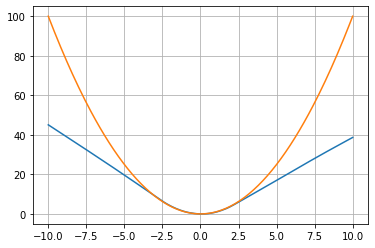

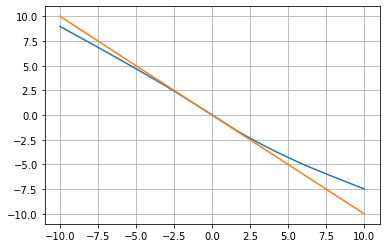

Optimal ergodic cost is:  1.007494


In [24]:
NN_plot(value_NN)
xgrid = np.linspace(-10,10,201)
plt.plot(xgrid, xgrid**2)
plt.show()
NN_plot(control_NN)
plt.plot(xgrid, -xgrid)
plt.show()
tmp = rho_NN.predict(np.zeros(1))[0,0]
print('Optimal ergodic cost is: ',tmp)

In [15]:
control_terminal.compile(loss = 'mse')

In [16]:
XT = control_terminal.predict(x_train)

(array([  7.,  22.,  78., 148., 249., 238., 148.,  79.,  25.,   6.]),
 array([-2.3211522 , -1.8504983 , -1.3798443 , -0.9091904 , -0.43853647,
         0.03211749,  0.50277144,  0.9734254 ,  1.4440793 ,  1.9147333 ,
         2.3853872 ], dtype=float32),
 <a list of 10 Patch objects>)

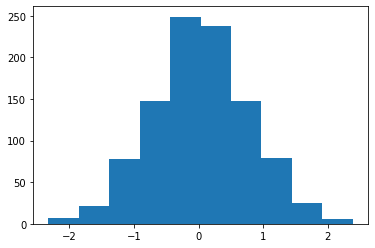

In [17]:
plt.hist(XT)

In [18]:
XT.mean(), XT.var()

(0.03210891, 0.5607608)

In [28]:
xt = np.random.normal(XT.mean(),XT.std(),size = (M,1))
xt_train, yt_train = trainning_data(10,XT,M)
xt_valid, yt_valid = trainning_data(20,XT,M)

In [29]:
control_optimal.compile(loss = square_loss , optimizer = 'Adam')
tmp = control_optimal.evaluate(xt_train,yt_train)
print('Loss under optimal control: ', tmp)

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0200
Loss under optimal control:  0.019982344463467597


In [31]:
control_main.compile(loss = square_loss , optimizer = custom_optimizer)
control_main.fit(xt_train,yt_train,epochs = 50,validation_data = (xt_valid,yt_valid), verbose = 1)
# control_main.compile(loss = square_loss , optimizer = custom_optimizer)
# control_main.fit(x_train,y_train,epochs = 20,validation_data = (x_valid,y_valid), verbose = 1)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 16s 16ms/sample - loss: 0.0227 - val_loss: 0.0223
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0226 - val_loss: 0.0238
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0237 - val_loss: 0.0242
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0247 - val_loss: 0.0235
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0284 - val_loss: 0.0265
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0326 - val_loss: 0.0336
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0309 - val_loss: 0.02080s - loss:
Epoch 8/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0222 - val_loss: 0.0200
Epoch 9/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0227 - val_loss: 0.0226
Epoc

KeyboardInterrupt: 

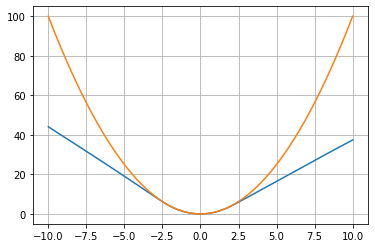

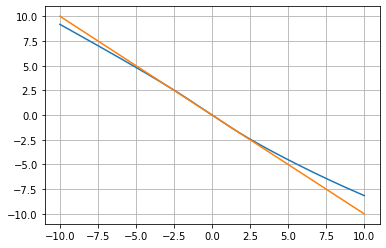

Optimal ergodic cost is:  1.0087371


In [32]:
NN_plot(value_NN)
xgrid = np.linspace(-10,10,201)
plt.plot(xgrid, xgrid**2)
plt.show()
NN_plot(control_NN)
plt.plot(xgrid, -xgrid)
plt.show()
tmp = rho_NN.predict(np.zeros(1))[0,0]
print('Optimal ergodic cost is: ',tmp)

In [33]:
xtt = control_terminal.predict(xt_train)

In [34]:
xtt.mean(), xtt.var()

(-0.0098901065, 0.50765306)